## Import Libraries

In [13]:
# #INITIATE code to train the network on the CPU
import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
#FINE codice per allenare la rete sulla cpu

import keras
import numpy as np
from keras.models import Sequential
from keras.layers import  Dense, Conv3D, Dropout, Flatten, BatchNormalization 
from keras.callbacks import EarlyStopping
from random import shuffle
import math
import matplotlib.pyplot as plt
import pandas as pd
#to plot the model
#from keras.utils.vis_utils import plot_model
#from keras.models import load_model
# Returns a compiled model identical to the saved one
#model = load_model('my_model.h5')

# PathSpectogramFolder='/home/sailam/Desktop/MSNE/Year 1 Semester 3/NISE/Project/Ex_projects/CNNs-on-CHB-MIT_edited/Results/Scalograms_first'
PathSpectogramFolder = '/floyd/input/epilepsy_nise_spectrogram'

# OutputPath='/home/sailam/Desktop/MSNE/Year 1 Semester 3/NISE/Project/Ex_projects/CNNs-on-CHB-MIT_edited/Results/trial_2.csv'
OutputPath='/floyd/home/Results'

# OutputPathModels='/home/sailam/Desktop/MSNE/Year 1 Semester 3/NISE/Project/Ex_projects/CNNs-on-CHB-MIT_edited/Results/models'
OutputPathModels='/floyd/home/Models'


interictalSpectograms=[]
preictalSpectograms=[]
preictalRealSpectograms=[]

# patients = ["01", "02", "05", "19", "21", "23"]
patients = ["01"]

nSeizure=0

def loadParametersFromFile(filePath):
    """This function loads the parameters from the 'PARAMETERS_CNN.txt' file
       Input: PARAMETERS_CNN.txt
       Output: None (Superceded the 'PathSpectogramFolder', 'OutputPath' and 'OutputPathModels' in the global variables)
    """
    global PathSpectogramFolder
    global OutputPath
    global OutputPathModels
    
    if(os.path.isfile(filePath)): # Check if file is there
        with open(filePath, "r") as f:
                line = f.readline() # Read first line
                if(line.split(":")[0] == "PathSpectogramFolder"):
                    PathSpectogramFolder = line.split(":")[1].strip() # Save the PathSpectogramFolder link
                line = f.readline() # Read next line
                
                if(line.split(":")[0] == "OutputPath"):
                    OutputPath = line.split(":")[1].strip() # Save the OutputPath link
                line=f.readline() # Read next line
                
                if(line.split(":")[0] == "OutputPathModels"):
                    OutputPathModels = line.split(":")[1].strip() # Save the OutputPathModels link

def loadSpectogramData(indexPat):
    """This function load the scalogram data from the folder
       Input: Index of the patient (01, 02, 03, etc..)
       Output: None (Interictal, Preictal and Real Preictal scalograms appended to list)
    """
    global interictalSpectograms
    global preictalSpectograms
    global preictalRealSpectograms
    global nSeizure
    
    nFileForSeizure = 0 # Initialize the number of seizure as zero
    
    interictalSpectograms = [] # Initialize the empty list for interictal scalograms
    preictalSpectograms = [] # Initialize the empty list for preictal scalograms
    preictalRealSpectograms = [] # Initialize the empty list for real preicatal scalograms
    
    f = open(PathSpectogramFolder+'/paz'+patients[indexPat]+'/legendAllData.txt', 'r') # Open legendAllData
    line = f.readline() # Read line
    
    while(not "SEIZURE" in line):
        line = f.readline() # Scroll to the line which 'SEIZURE' appears
        
    nSeizure = int(line.split(":")[1].strip()) # Store the number of seizure
    line=f.readline() # Read whether if it is 'Interictal', 'Preictal' or 'Real Preictal'
    line=f.readline() # Read the total number of interictal scalograms
    
    nSpectograms = int(line.strip()) # Total number of interictal scalograms
    nFileForSeizure = math.ceil(math.ceil(nSpectograms/50) / nSeizure) # Number of file for seizures
    line = f.readline()
    
    # Reading path files in Interictal
    cont = -1 # Need to set as '0' so that we can increase the counter in the 'if' loop
    indFilePathRead = 0
    
    while("npy" in line and indFilePathRead < nSeizure*nFileForSeizure): # Read individual Interictal files
        if(indFilePathRead%nFileForSeizure == 0):
            interictalSpectograms.append([]) # Append empty list in the original list
            cont = cont+1 # Start as '0'
            interictalSpectograms[cont].append(line.split(' ')[2].rstrip())# Append the file path of interictal seizures (rstrip() to remove \n)
            indFilePathRead = indFilePathRead+1
        else:
            if(len(line.split(' '))>=3):
                interictalSpectograms[cont].append(line.split(' ')[2].rstrip())
            indFilePathRead=indFilePathRead+1
            
        line = f.readline() # Read the next interictal file
        
    line = f.readline() # Read PREICTAL
    line = f.readline() # Read the total number of preictal scalograms
    line = f.readline() # Read (SEIZURE 0)

    # Reading path files Preictal
    cont=-1
    indFilePathRead=0   
    while(line.strip()!=""):
        if("SEIZURE" in line):
            line = f.readline() # Read number of seizure (SEIZURE 0, SEIZURE 1, etc)
            if(len(line.split(' '))>=3):
                preictalSpectograms.append([])
                cont=cont+1
                preictalSpectograms[cont].append(line.split(' ')[2].rstrip())
                indFilePathRead=indFilePathRead+1
        else:
            if(len(line.split(' '))>=3):
                preictalSpectograms[cont].append(line.split(' ')[2].rstrip())
            indFilePathRead=indFilePathRead+1
            
        line=f.readline() # Read the next preictal file
        
    line=f.readline() # Read REAL_PREICTAL
    line=f.readline() # Read the total number of preictal scalogramsRead 'n' spectogram
    line=f.readline() # Read (SEIZURE 0)

    # Reading path files of Real Preictal
    cont=-1
    while(line):
        if("SEIZURE" in line):
            line=f.readline() # Read number of seizure (SEIZURE 0, SEIZURE 1, etc)
            preictalRealSpectograms.append([])
            cont=cont+1
            preictalRealSpectograms[cont].append(line.split(' ')[2].rstrip())
        else:
            preictalRealSpectograms[cont].append(line.split(' ')[2].rstrip())
            
        line=f.readline()
    f.close() # Close the file

def createModel():
    input_shape=(1, 22, 59, 114)
    model = Sequential()
    #C1
    model.add(Conv3D(16, (22,5,5), strides=(1,2,2), padding='valid',activation='relu',data_format= "channels_first", input_shape=input_shape))
    model.add(keras.layers.MaxPooling3D(pool_size=(1,2,2),data_format= "channels_first",  padding='same'))
    model.add(BatchNormalization())
    
    #C2
    model.add(Conv3D(32, (1,3,3), strides=(1,1,1), padding='valid',data_format= "channels_first",  activation='relu'))#incertezza se togliere padding
    model.add(keras.layers.MaxPooling3D(pool_size=(1,2,2),data_format= "channels_first", ))
    model.add(BatchNormalization())
    
    #C3
    model.add(Conv3D(64, (1,3,3), strides=(1,1,1), padding='valid',data_format= "channels_first",  activation='relu'))#incertezza se togliere padding
    model.add(keras.layers.MaxPooling3D(pool_size=(1,2,2),data_format= "channels_first", ))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    
    opt_adam = keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=opt_adam, metrics=['accuracy'])
    
    return model

def getFilesPathWithoutSeizure(indexSeizure, indexPat):
    """This function returns a suffled file path of interictal and preictal data.
       Input: Seizure index (0 to 6)(Total number of Seizure is 7), Patient index (0,1,2, etc)
       Output: Files Path of interictal and preictal data
    """
    filesPath = [] # Initialize an empty file path
    
    for i in range(0, nSeizure):
        if(i != indexSeizure):
            filesPath.extend(interictalSpectograms[i])
            filesPath.extend(preictalSpectograms[i])
    shuffle(filesPath)
    
    return filesPath


def generate_arrays_for_training(indexPat, paths, start=0, end=100):
    """This function generates the training data for the neural network.
       Input: Patient index (01, 02, 03, etc), File paths, start = 0, end = 100 (the length of data to feed into the neural network at one go)
       Output: Training data (Scalograms), Labels (Depending on whether it is preictal or interictal)
    """    
    while True:
        
        # Select the total of file path data to process
        from_=int(len(paths)/100*start) 
        to_=int(len(paths)/100*end)
        
        for i in range(from_, int(to_)):
            
            f = paths[i] # Read individual file path of the data
            x = np.load(PathSpectogramFolder+f) # Load the stored scalograms
            x = np.array([x]) # Enclosed into an empty array
            x = x.swapaxes(0,1) # Swap the first and second dimension of the data
            
            if('P' in f): 
                y = np.repeat([[0,1]],x.shape[0], axis=0) # Label as [0,1] if preictal
            else:
                y =np.repeat([[1,0]],x.shape[0], axis=0) # Label as [1,0] if interictal
                
            yield(x,y) # Return the scalograms and labels
            
def generate_arrays_for_predict(indexPat, paths, start=0, end=100):
    """This function generates the data for prediction with the neural network.
       Input: Patient index (01, 02, 03, etc), File paths, start = 0, end = 100 (the length of data to predict at one go)
       Output: Data for prediction (Can be interictal or real_preictal)
    """
    while True:
        from_=int(len(paths)/100*start)
        to_=int(len(paths)/100*end)
        for i in range(from_, int(to_)):
            f=paths[i]
            x = np.load(PathSpectogramFolder+f)
            x=np.array([x])
            x=x.swapaxes(0,1)
            yield(x)

class EarlyStoppingByLossVal(keras.callbacks.Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0, lower=True):
        super(keras.callbacks.Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose
        self.lower=lower

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if self.lower:
            if current < self.value:
                if self.verbose > 0:
                    print("Epoch %05d: early stopping THR" % epoch)
                self.model.stop_training = True
        else:
            if current > self.value:
                if self.verbose > 0:
                    print("Epoch %05d: early stopping THR" % epoch)
                self.model.stop_training = True

### New Function to plot graph

In [14]:
def print_load_acc_loss(history,i,j):
     ### plot accuracy and loss
    # summarize history for accuracy
    acc=history.history['acc']
    val_acc=history.history['val_acc']
    loss=history.history['loss']
    val_loss=history.history['val_loss']

    plt.figure(figsize=(20,10))
    plt.plot(acc)
    plt.plot(val_acc)
    plt.title('Model Accuracy', fontsize=24)
    plt.ylabel('Accuracy', fontsize=20)
    plt.xlabel('Epochs', fontsize=20)
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(OutputPath+'/'+'seizure_'+str(i)+'_accuracy_'+str(j)+'acc.png')
    plt.show()

    # summarize history for loss
    plt.figure(figsize=(20,10))
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model Loss', fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.xlabel('Epochs', fontsize=20)
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(OutputPath+'/'+'seizure_'+str(i)+'_accuracy_'+str(j)+'loss.png')
    plt.show()


#     dataframe = pd.DataFrame({'accuracy':acc,'validation_accuracy':val_acc,'loss':loss,'validation_loss':val_loss})
#     dataframe.to_csv(OutputPath+'/'+'Accu_and_Loss'+'/'+'seizure'+str(i)+'AccALoss_'+str(j)+'.csv') ## save accuracy and loss


In [15]:
def main():
    
    print("START")
    
    if not os.path.exists(OutputPathModels):
        os.makedirs(OutputPathModels)
    loadParametersFromFile("PARAMETERS_CNN.txt")
    print("Parameters loaded")
    
    # Create the callback
    callback = EarlyStoppingByLossVal(monitor='val_acc', value=0.975, verbose=1, lower=False)
    
    
    for indexPat in range(0, len(patients)):
        print('Patient '+patients[indexPat])
        if not os.path.exists(OutputPathModels+"ModelPat"+patients[indexPat]+"/"):
            os.makedirs(OutputPathModels+"ModelPat"+patients[indexPat]+"/")
        loadSpectogramData(indexPat) 
        print('Spectograms data loaded')
        
        result='Patient '+patients[indexPat]+'\n'     
        result='Out Seizure, True Positive, False Positive, False negative, Second of Inter in Test, Sensitivity, FPR \n'
        for i in range(0, nSeizure):
            
            print('SEIZURE OUT: '+str(i+1))
            print('Training start')
            
            model = createModel() # Create the CNN model
            filesPath = getFilesPathWithoutSeizure(i, indexPat) # Obtain the file paths of the preictal and interictal data
            
            # Initiate the training using the CNN model
            history = model.fit_generator(generate_arrays_for_training(indexPat, filesPath, end=75), # Take the first 75% of the data for training
                                validation_data=generate_arrays_for_training(indexPat, filesPath, start=75),# Take the last 25% of the data for validation
                                steps_per_epoch=int((len(filesPath)-int(len(filesPath)/100*25))), # Based on the number of training data
                                validation_steps=int((len(filesPath)-int(len(filesPath)/100*75))), # Based on the number of validation data
                                verbose=2, # Print one line per epoch.
                                epochs=100, max_queue_size=2, shuffle=True, callbacks=[callback]) # 100 epochs is better # add stop criteria based on accuracy
            print('Training end')
            
            # Calling the function to print graph
            print_load_acc_loss(history,i,1)
            
            print('Testing start')
            
            filesPath = interictalSpectograms[i]
            interPrediction = model.predict_generator(generate_arrays_for_predict(indexPat, filesPath), max_queue_size=4, steps=len(filesPath))
            filesPath = preictalRealSpectograms[i]
            preictPrediction=model.predict_generator(generate_arrays_for_predict(indexPat, filesPath), max_queue_size=4, steps=len(filesPath))
            
            print('Testing end')
            

            # Saving the model (HDF5 file) 
            model.save(OutputPathModels+"ModelPat"+patients[indexPat]+"/"+'ModelOutSeizure'+str(i+1)+'.h5')
            print("Model saved")
            
            # Saving the predicted results using interictal and preictal data
            if not os.path.exists(OutputPathModels+"OutputTest"+"/"):
                os.makedirs(OutputPathModels+"OutputTest"+"/")
            
            np.savetxt(OutputPathModels+"OutputTest"+"/"+"Int_"+patients[indexPat]+"_"+str(i+1)+".csv", interPrediction, delimiter=",")
            np.savetxt(OutputPathModels+"OutputTest"+"/"+"Pre_"+patients[indexPat]+"_"+str(i+1)+".csv", preictPrediction, delimiter=",")
            
            # Convert the scalograms to seconds (50 scalograms file, 10 seconds for each scalogram)
            secondsInterictalInTest = len(interictalSpectograms[i])*50*10
            
            acc = 0 # Accumulator
            fp = 0 # False positive
            tp = 0 # True positive
            fn = 0 # False negative
            lastTenResult = list() # Set an empty list to contain the last 10 results
            
            # Calculate the false postive using interictal scalograms
            for el in interPrediction: # Read each row
                if(el[1]>0.5): # Second column
                    acc = acc+1 # Increase the acc by 1
                    lastTenResult.append(1) # Add '1' into the list                  
                else:
                    lastTenResult.append(0) # Add '0' into the list
            
                # Compute the false positive for every 10 counts
                if(len(lastTenResult)>10):
                    acc = acc-lastTenResult.pop(0) # Minus the last count
                    
                if(acc >= 8): # If 8 or more is '1'  
                    fp = fp+1 # Add false positive count
                    lastTenResult=list() # Reset the list
                    acc = 0 # Reset the accuracy
                    
            lastTenResult=list() # Reset the list
            
            # Compute the true positive using preictal scalograms
            for el in preictPrediction: # Read each row
                if(el[1]>0.5): # Second column
                    acc = acc+1 # Increase the acc by 1
                    lastTenResult.append(1) # Add '1' into the list 
                else:
                    lastTenResult.append(0) # Add '0' into the list
                
                # Compute the true positive for every 10 counts
                if(len(lastTenResult)>10):
                    acc = acc-lastTenResult.pop(0) # Minus the last count
                    
                if(acc >= 8): # If 8 or more is '1'
                    tp = tp+1 # Add true positive count
                else:
                    if(len(lastTenResult)==10):
                        fn = fn+1 # Add false negative count
            
            # Compute the Sensitivity
            sensitivity = tp / (tp+fn)
            
            # Compute the False Positive Rate (FPR)
            FPR = fp / (secondsInterictalInTest/(60*60))
            
            # Print and save the results
            result = result+str(i+1)+','+str(tp)+','+str(fp)+','+str(fn)+','+str(secondsInterictalInTest)+','
            result = result+str(sensitivity)+','+str(FPR)+'\n'
            print('True Positive, False Positive, False negative, Second of Inter in Test, Sensitivity, FPR')
            print(str(tp)+','+str(fp)+','+str(fn)+','+str(secondsInterictalInTest)+','+str(sensitivity)+','+str(FPR))
          
        with open(OutputPath+'/'+'result.csv', "a+") as myfile:
            myfile.write(result)   

START
Parameters loaded
Patient 01
Spectograms data loaded
SEIZURE OUT: 1
Training start
Epoch 1/100
 - 5s - loss: 0.9162 - acc: 0.4953 - val_loss: 0.6744 - val_acc: 0.5362
Epoch 2/100
 - 3s - loss: 0.8664 - acc: 0.4923 - val_loss: 0.6600 - val_acc: 0.6743
Epoch 3/100
 - 3s - loss: 0.8405 - acc: 0.5168 - val_loss: 0.6586 - val_acc: 0.7373
Epoch 4/100
 - 3s - loss: 0.8254 - acc: 0.5254 - val_loss: 0.6581 - val_acc: 0.7319
Epoch 5/100
 - 3s - loss: 0.8174 - acc: 0.5314 - val_loss: 0.6540 - val_acc: 0.7239
Epoch 6/100
 - 3s - loss: 0.7768 - acc: 0.5401 - val_loss: 0.6454 - val_acc: 0.7466
Epoch 7/100
 - 3s - loss: 0.7918 - acc: 0.5461 - val_loss: 0.6368 - val_acc: 0.7802
Epoch 8/100
 - 3s - loss: 0.7570 - acc: 0.5552 - val_loss: 0.6237 - val_acc: 0.7440
Epoch 9/100
 - 3s - loss: 0.7570 - acc: 0.5621 - val_loss: 0.6014 - val_acc: 0.8097
Epoch 10/100
 - 3s - loss: 0.7066 - acc: 0.6052 - val_loss: 0.5965 - val_acc: 0.7962
Epoch 11/100
 - 3s - loss: 0.7046 - acc: 0.6045 - val_loss: 0.5773 - v

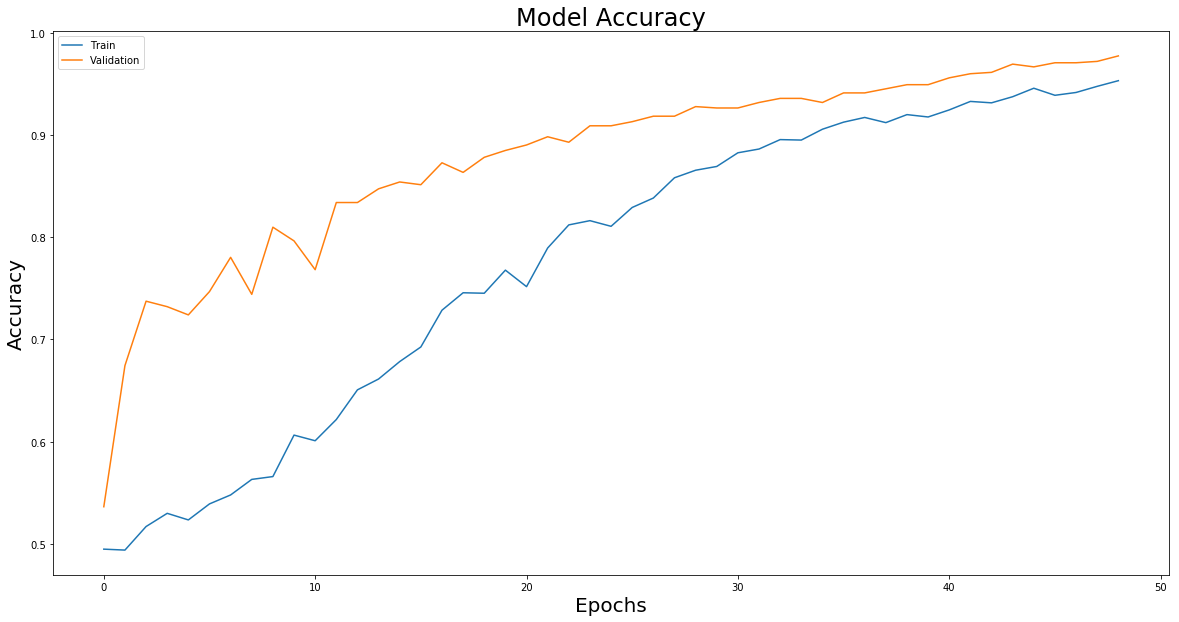

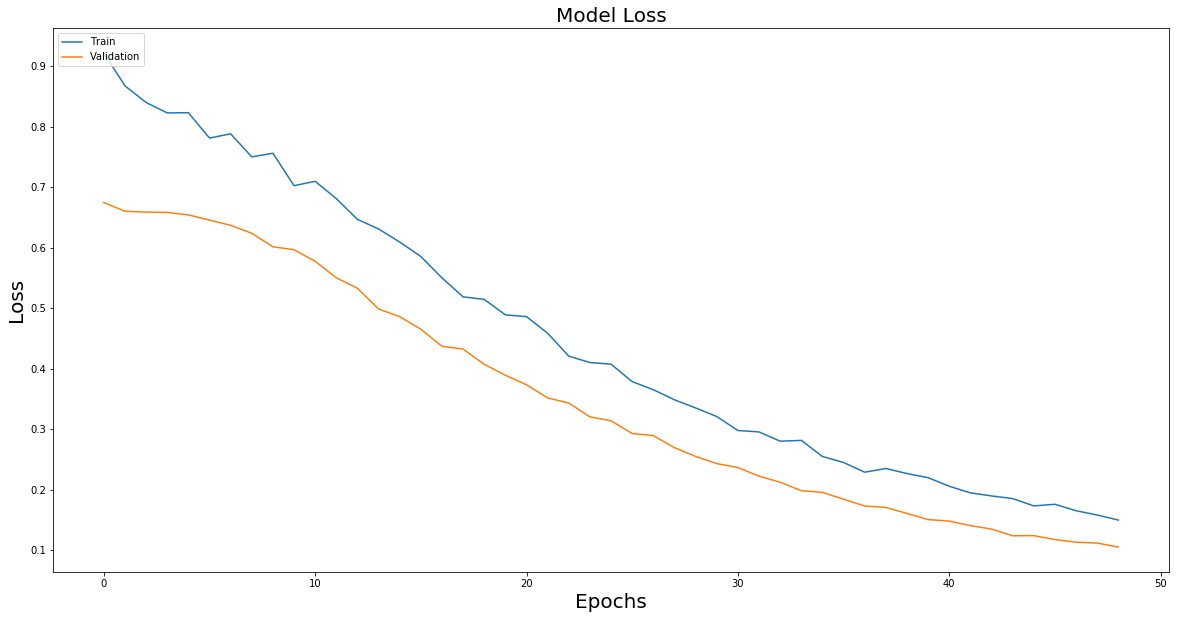

Testing start
Testing end
Model saved
True Positive, False Positive, False negative, Second of Inter in Test, Sensitivity, FPR
55,17,0,2500,1.0,24.48
SEIZURE OUT: 2
Training start
Epoch 1/100
 - 6s - loss: 0.8609 - acc: 0.4984 - val_loss: 0.6970 - val_acc: 0.4426
Epoch 2/100
 - 3s - loss: 0.8352 - acc: 0.5204 - val_loss: 0.6901 - val_acc: 0.4873
Epoch 3/100
 - 3s - loss: 0.8325 - acc: 0.5147 - val_loss: 0.6937 - val_acc: 0.4426
Epoch 4/100
 - 3s - loss: 0.8422 - acc: 0.4991 - val_loss: 0.6877 - val_acc: 0.5142
Epoch 5/100
 - 3s - loss: 0.8336 - acc: 0.4986 - val_loss: 0.6856 - val_acc: 0.5276
Epoch 6/100
 - 3s - loss: 0.8229 - acc: 0.5249 - val_loss: 0.6815 - val_acc: 0.5917
Epoch 7/100
 - 3s - loss: 0.8147 - acc: 0.5333 - val_loss: 0.6717 - val_acc: 0.6617
Epoch 8/100
 - 3s - loss: 0.8184 - acc: 0.5328 - val_loss: 0.6841 - val_acc: 0.5544
Epoch 9/100
 - 3s - loss: 0.8223 - acc: 0.5267 - val_loss: 0.6766 - val_acc: 0.6408
Epoch 10/100
 - 3s - loss: 0.8015 - acc: 0.5164 - val_loss: 0.67

In [ ]:
main()